In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

np.random.seed(100)

In [2]:
def halflife(series, method="numpy_no_intercept"):
    if method == "numpy_no_intercept":
        lambda_ = np.linalg.lstsq(
            series[:-1].values[:, np.newaxis],
            series[1:].values[:, np.newaxis],
            rcond=None,
        )[0].item()

    elif method == "statsmodels_no_intercept":
        lambda_ = AutoReg(series, lags=1, trend="n").fit().params["y.L1"]

    elif method == "numpy_intercept":
        lambda_ = np.polynomial.Polynomial.fit(
            series.shift(1).iloc[1:], series.iloc[1:], deg=1, domain=[]
        ).coef[1]

    elif method == "statsmodels_intercept":
        lambda_ = AutoReg(series, lags=1).fit().params["y.L1"]

    if 0 < lambda_ and lambda_ < 1:
        return -np.log(2) / np.log(lambda_)
    else:
        return np.NaN

In [3]:
color_map = {
    "numpy_no_intercept": "blue",
    "numpy_intercept": "red",
    "statsmodels_no_intercept": "green",
    "statsmodels_intercept": "orange",
}

In [4]:
def plot_halflife(series):
    # 绘制柱状图
    plt.figure(figsize=(10, 5))
    plt.bar(series.index, series.values, color="skyblue")
    plt.xlabel("Time")
    plt.ylabel("Value")

    # 绘制半衰期的垂直虚线
    for method in [
        "numpy_no_intercept",
        "statsmodels_no_intercept",
        "numpy_intercept",
        "statsmodels_intercept",
    ]:
        halflife_ = halflife(series, method)
        if not np.isnan(halflife_):
            plt.axvline(
                # 为了让虚线不重叠，加上一个随机扰动
                x=halflife_ + np.random.normal(0, 0.1),
                color=color_map[method],
                linestyle="--",
                label=f"{method} = {halflife_:.2f}",
            )
            plt.legend()
    # # 纵坐标的范围
    # plt.ylim(-100, 100)
    plt.show()

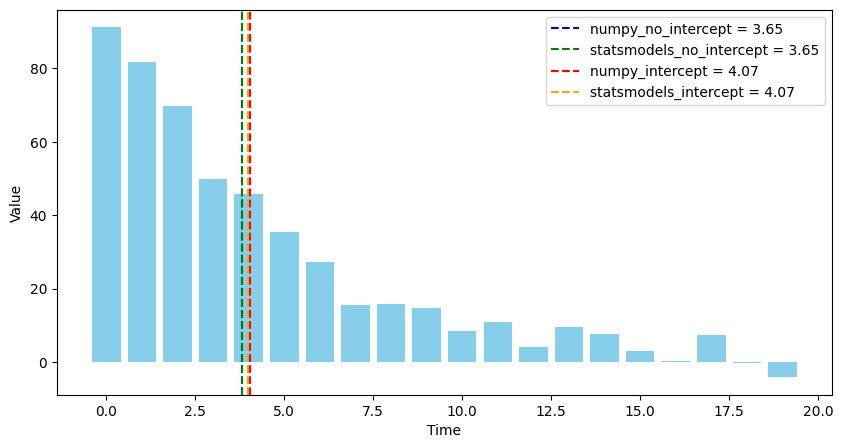

In [5]:
# 创建衰减到 0 的 Series
data = 100 * 0.8 ** np.arange(20) + np.random.normal(0, 5, 20)
plot_halflife(pd.Series(data))

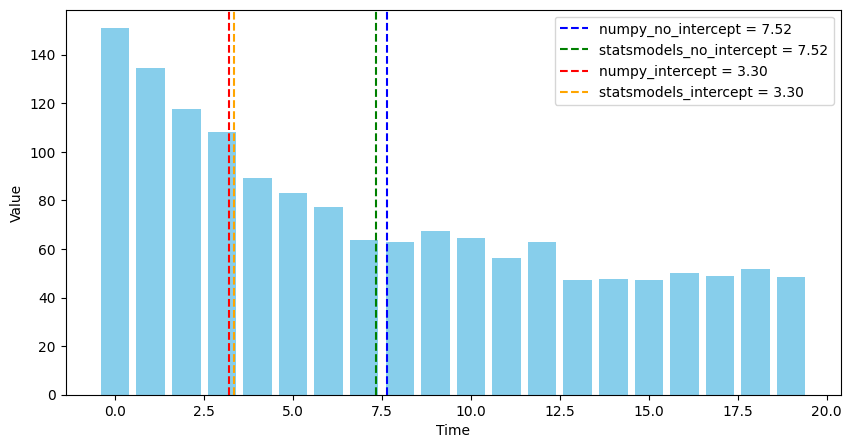

In [6]:
# 创建衰减到 50 的 Series
data = 50 + 100 * 0.8 ** np.arange(20) + np.random.normal(0, 5, 20)
plot_halflife(pd.Series(data))

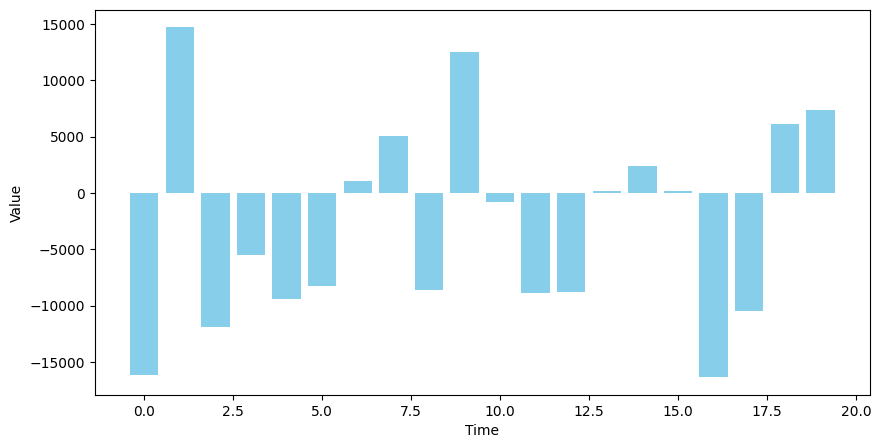

In [7]:
# 创建不规律的 Series
data = np.random.normal(0, 10000, 20)
plot_halflife(pd.Series(data))

### 代码耗时

In [8]:
data = 100 * 0.8 ** np.arange(20) + np.random.normal(0, 5, 20)
series = pd.Series(data)

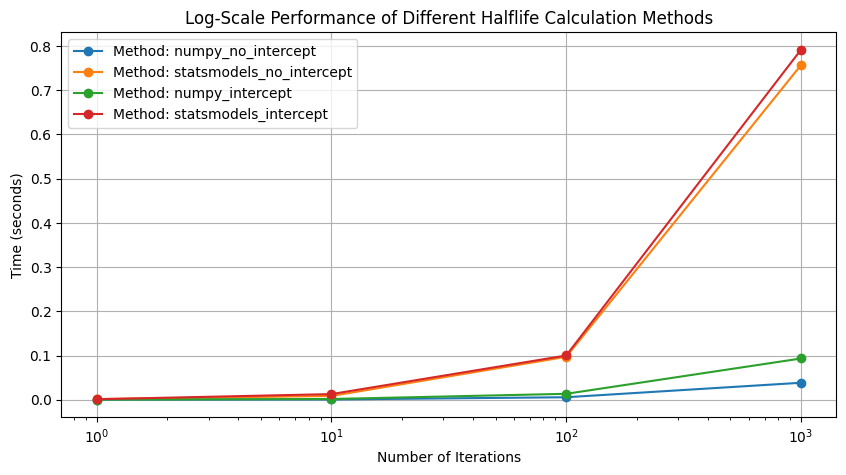

In [9]:
# 定义需要测试的方法
methods = [
    "numpy_no_intercept",
    "statsmodels_no_intercept",
    "numpy_intercept",
    "statsmodels_intercept",
]
iterations = [1, 10, 100, 1000]  # 不同的迭代次数
times = {method: [] for method in methods}

# 计时
for iteration in iterations:
    for method in methods:
        start_time = time.time()
        for _ in range(iteration):
            halflife(series, method)
        end_time = time.time()
        elapsed_time = end_time - start_time
        times[method].append(elapsed_time)

# 绘制对数折线图
plt.figure(figsize=(10, 5))
for method, timing in times.items():
    plt.plot(iterations, timing, label=f"Method: {method}", marker="o")

plt.xscale("log")
plt.yscale("linear")
plt.ylabel("Time (seconds)")
plt.xlabel("Number of Iterations")
plt.title("Log-Scale Performance of Different Halflife Calculation Methods")
plt.legend()
plt.grid(True)
plt.show()